# ランダムフォレスト

In [1]:
# 定型ライブラリ読み込み
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from scipy import stats
from numpy.random import randn
from numpy.random import randint
import copy
import statistics

from sklearn.datasets import load_iris
import pandas as pd

C:\Users\YusukeSato\Anaconda3\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## 損失関数を定義

In [2]:
##　二乗誤差
def sq_loss(y):
    if len(y) == 0:
        return 0
    else:
        y_bar = np.mean(y)
        return np.linalg.norm(y-y_bar)**2  # L2ノルムを計算し二乗している

In [3]:
## 頻度
### 各要素の頻度を算出
def freq(y):
    y = list(y)
    return [y.count(i) for i in set(y)]

In [4]:
## 最頻値
def mode(y):
    n = len(y)
    if n == 0:
        return 0
    return max(freq(y))

In [5]:
# 誤り数
def mis_match(y):
    return len(y) - mode(y)

In [6]:
# Gini
def gini(y):
    n = len(y)
    if n == 0:
        return 0
    fr = freq
    return sum([fr[i]/n * (n - fr[i]) for i in range(len(fr))])

In [7]:
# Entropy
def entropy(y):
    n = len(y)
    if n == 0:
        return 0
    freq = [y.count(i) for i in set(y)]
    return np.sum([-freq[i] * np.log(freq[i]/n) for i in range(len(freq))])

In [8]:
def mode_max(y):
    if len(y) == 0:
        return -np.inf
    count = np.bincount(y)
    return np.argmax(count)

## 実行用の関数を定義

In [9]:
# 枝の分割
# 総当たり計算を実施
    # 1. 各変数それぞれに対して
    # 2. あるデータiを選択したときに
    # 3. データiを閾値としてそれより小さいものをleft,以上をrightに格納
    # 4. 分割したときの損失関数を算出
    # 5. 損失関数が過去最少であった場合、閾値とデータ集合を更新
def branch(x, y, S, rf = 0):
    # x:入力データ
    # y:ターゲットデータ
    # S:変数jにおける全データを格納
    # rf:ランダムフォレストの実施の有無？
    if rf == 0:
        T = np.arange(x.shape[1])   # mに変数の個数を格納
    else:
        T = np.random.choice(x.shape[1], rf, replace=False)  # rfは選択する変数の個数を表す
    if x.shape[0] == 0:  # データがないとき？
        return([0,0,0,0,0,0,0])
    
    #print(S)
    
    best_score = np.inf  # スコアをinfに設定し、最小値を探す
    
    for j in T:     # 変数の数だけループ
        for i in S:                 # 後で出てくるコードでSにpoppedを格納している popはオプションなしで指定した配列の最後の要素を取り出す
            left = []; right = []   # 枝の左右を初期化、left,rightはそれぞれの枝に入ったindexのリストである
            for k in S:
                if x[k,j] < x[i,j]:  # 枝の左右への振り分け j番目の変数におけるi番目のデータを閾値としたときの振り分けを実施
                    left.append(k)   # 左に入ったデータのindexのリストに新たにindexを追加
                else:
                    right.append(k)  # 右に入ったデータのindexのリストに新たにindexを追加
            left_score = f(y[left])           # 左側の損失関数を計算
            right_score = f(y[right])         # 右側の損失関数を計算
            score = left_score + right_score  # 合計値をスコアとする
            
            if score < best_score:                                      # スコアが過去のものより良い場合
                best_score = score                                      # スコアの最小値を更新
                i_1 = i; j_1 = j                                        # スコアが前回よりも小さい場合の閾値iと変数jのindexを格納
                left_1 = left; right_1 = right                          # 分割されたデータ集合left,rightのindexを格納
                left_score_1 = left_score; right_score_1 = right_score  # left,rightそれぞれの現時点での最小値を格納
                
    return [i_1, j_1, left_1, right_1, best_score, left_score_1, right_score_1]  # 返却

In [10]:
# データスタック
    # データ格納用にクラスを利用
class Stack:
    def __init__(self, parent, set, score):
        self.parent = parent   # 親ノードの番号
        self.set = set         # データのindexリスト
        self.score = score     # 損失関数
        
# ノード
    # データ格納用にクラスを利用
class Node:
    def __init__(self, parent, j, th, set):
        # parent:親ノードの番号
        # j:自身のノード番号
        # th:分岐の際の閾値
        # set:ノード内のデータ集合のindexリスト
        self.parent = parent
        self.j = j
        self.th = th
        self.set = set

In [11]:
# 枝を伸ばす
def dt(x, y, alpha = 0, n_min = 1, rf = 0):
    # x:入力データ
    # y:ターゲットデータ
    # alpha:後で利用
    # n_min:各ノードにおけるデータ集合の最小値
    # rf:ランダムフォレストを実行する際に利用する変数の数
    if rf == 0:
        m = x.shape[1]
    
    stack = [Stack(0, list(range(x.shape[0])), f(y))]   # stackを初期化
    node = []   # nodeを初期化
    k = -1      # kを初期化
    
    # stackに何かしらデータが残っている間のループ
    while len(stack) > 0:
        popped = stack.pop()   # stackの最後のデータを取り出してpoppedに格納
        #print(popped.parent, popped.score, popped.set)

        k = k + 1
        i, j, left, right, score, left_score, right_score = branch(x, y, popped.set, rf)  # 枝の分割を計算 Sにはpopped.setを入れる
        if popped.score - score < alpha or len(popped.set) < n_min or len(left) == 0 or len(right) == 0:
            # 以下の条件を満たすとき、枝をそこで止める
            ## 1. 一回前とのスコアの差分が閾値alphaより小さい
            ## 2. ノードのデータ集合数がn_minより小さい
            ## 3. 左の枝が空集合
            ## 4. 右の枝が空集合
            node.append(Node(popped.parent, -1, 0, popped.set))
        else:
            node.append(Node(popped.parent, j, x[i,j], popped.set))
            stack.append(Stack(k, right, right_score))
            stack.append(Stack(k, left, left_score))
    ### 枝を伸ばす処理はここまで
    
    # ノードの分岐構造をデータにする
    for h in range(k, -1, -1):
        # kは枝の数
        # 各ノードにleft, rightを設定する、そのための初期化
        node[h].left = 0
        node[h].right = 0

    for h in range(k, 0, -1):  # kから降順で最後の値の一つ手前まで
        pa = node[h].parent       # node[h]の親ノードをpaに格納
        #print(h, pa)
        if node[pa].right == 0:   # node[h]の親ノードの右側にまだ値が格納されていない場合
            node[pa].right = h   # node[h]をその親ノードのrightに格納
        else:                     # そうでない場合
            node[pa].left = h    # node[h]をその親ノードのleftに格納
        #print(h, pa, node[pa].right, node[pa].left)
    
    # 
    if f == sq_loss:      # 損失関数を二乗誤差にした場合の処理
        g = np.mean       # 平均値を引数に与える関数とする
    else:
        g = mode_max      # 中央値を引数に与える関数とする
    for h in range(k+1):
        if node[h].j == -1:    # ノードが枝分かれしていない場合
            node[h].center = g(y[node[h].set])    # そのノードの集合におけるターゲットの平均もしくは最頻値をそのノードのcenterとする
        else:
            node[h].center = 0                    # ノードが枝分かれしている場合はcenterを決めずとする
            
    return node

In [12]:
# 計算済みのモデルを使って新しいデータに対する予測値を計算
def value(u, node):
    # u:入力データ
    # node:計算済みのモデル
    r = 0    # 初期化
    
    #print(u)
    
    # 端点に達するまでループ
    while node[r].j != -1:
        #print(r)
        #print(node[r].left, node[r].right)
        if u[node[r].j] < node[r].th:   # 入力値が閾値よりも小さい場合、左のノードへ
            #print(node[r].left)
            #print(u[node[r].j], node[r].th)
            r = node[r].left
        else:                           # 入力値が閾値以上の場合、右のノードへ
            #print(node[r].right)
            r = node[r].right
    return node[r].center               # 端点に達した時、端点が格納しているcenterの値を返す

## フィッシャーのirisのデータで実験

In [13]:
# 正当数を計算する
def rf(z):
    z = np.array(z, dtype=np.int64)
    zz = []
    for b in range(B):
        u = sum([mode_max(z[range(b+1),i]) == y[i+100] for i in range(50)])
        zz.append(u)
    return zz

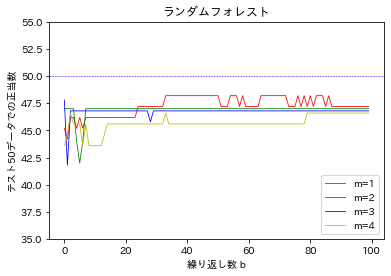

In [19]:
# データ作成
iris = load_iris()                              # データをロード
iris.target_names                               # 変数名を表示？
f = mis_match                                   # 損失関数をmis_matchに設定
n = iris.data.shape[0]                          # n数を算出（配列の行数）
order = np.random.choice(n, n, replace=False)   # データをランダムに並び替えするためのindexの並びを生成

X = iris.data[order, :]   # 入力データを並び替え
y = iris.target[order]    # ターゲットデータを並び替え

# トレーニングセットとテストセットに分割
train = list(range(100))          # 最初の100個をトレーニングセットに
test = list(range(100, 150))      # 後ろの50個をテストセットに

# 初期設定
B = 100  # 木の数

# 描画用の設定
plt.ylim([35,55])
m_seq = [1,2,3,4]
c_seq = ['r', 'g', 'b', 'y']
label_seq = ['m=1', 'm=2', 'm=3', 'm=4']
plt.xlabel('繰り返し数 b')
plt.ylabel('テスト50データでの正当数')
plt.title('ランダムフォレスト')

# 実行
for m in m_seq:
    # 予測値を格納する配列を初期化
    z = np.zeros((B, 50))
    
    # 指定した木の数だけ、決定木を作る関数をループさせる
    for b in range(B):
        index = np.random.choice(train, 100, replace = True)   # トレーニングセットから重複ありでデータをサンプリング
        node = dt(X[index, :], y[index], n_min = 2, rf = m)    # サンプリングしたデータで変数の個数mで木を生成
        
        # 生成された木で各テストデータの予測値を計算
        for i in test:
            z[b, i-100] = value(X[i,], node)
            
    # 正答率のラインを描画する
    plt.plot(list(range(B)),
             np.array(rf(z))-0.2*(m-2),
             label = label_seq[m-1],
             linewidth = 0.8,
             c = c_seq[m-1])
plt.legend(loc = 'lower right')
plt.axhline(y = 50,
            c = 'b',
            linewidth = 0.5,
            linestyle = 'dashed')